In [3]:
import numpy as np
from pr2_utils import *
import matplotlib.pyplot as plt

# Variables for Lidar to Body Transformation

T_L2B                       = np.array([[0.8349, -0.0126869, 1.76416]])
R_L2B                       = np.array([ [0.00130201, 0.796097, 0.605167],
                                         [0.999999, -0.000419027, -0.00160026],
                                         [-0.00102038, 0.605169, -0.796097] ])

# Lidar Parameters

FOV_Lidar                   = 190   # Degrees
start_Angle_Lidar           = -5    # Degrees
end_Angle_Lidar             = 185   # Degrees
resolution_Lidar            = 0.666 # Degrees
max_Range_Lidar             = 80    # meter

def process_Lidar_Data(data_Lidar, particle_state):

    # Variable Definitions
    Coordinates                 = []
    angle                       = 0
    xs_0                     = np.zeros(286)
    ys_0                     = np.zeros(286)

    # Calculate x and y co-ordinates from the Lidar Value
    for i in range( len( data_Lidar ) ):
        angle = start_Angle_Lidar + ( i * resolution_Lidar )
        temp = [0,0]

        # Filter Lidar data with range less than 2m and greater than 75m
        if data_Lidar[i] > 2 and data_Lidar[i] < 75:
            temp[0] = data_Lidar[i] * ( np.cos( np.deg2rad( angle ) ) )
            temp[1] = data_Lidar[i] * ( np.sin( np.deg2rad( angle ) ) )
            Coordinates.append(temp)

    # Conversion from Lidar to World frame

    # Formation of pose matrix for Sensor to Body Frame transformation
    pose_Matrix_L2B = np.concatenate( ( R_L2B, T_L2B.T ), axis = 1 )
    pose_Matrix_L2B = np.concatenate( ( pose_Matrix_L2B, np.array( [[0,0,0,1]] ) ), axis = 0 )

    # Formation of pose matrix for Body to World Frame transformation
    theta           = particle_state[2]

    R_B2W           = np.array([ [np.cos(theta), -np.sin(theta), 0],
                                 [np.sin(theta), np.cos(theta), 0],
                                 [0, 0, 1] ])

    pose_Matrix_B2W = np.concatenate( ( R_B2W, np.array( [[particle_state[0], particle_state[1], 0]] ).T ), axis = 1 )
    pose_Matrix_B2W = np.concatenate( ( pose_Matrix_B2W, np.array( [[0,0,0,1]] ) ), axis = 0 )

    # Formation of final pose matrix for Senor to World Frame transformation
    pose_Matrix     = np.dot(pose_Matrix_B2W, pose_Matrix_L2B)

    for i in range(len(Coordinates)):
        temp = [Coordinates[i][0], Coordinates[i][1], 0, 1 ]
        temp = np.dot(pose_Matrix, temp)
        #if temp[2] < 3:
        xs_0[i] = temp[0]
        ys_0[i] = temp[1]

    xs_0 = xs_0[xs_0 != 0]
    ys_0 = ys_0[ys_0 != 0]

    return xs_0, ys_0


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pr2_utils import *
# from process_lidar_data import process_Lidar_Data


# Function Definitions

def initialize_Lidar():

    timestamp, data = read_data_from_csv('data/sensor_data/lidar.csv')

    return timestamp, data

def initialize_Encoder():

    timestamp, data = read_data_from_csv('data/sensor_data/encoder.csv')

    return timestamp, data

def initialize_FOG():

    timestamp, data = read_data_from_csv('data/sensor_data/fog.csv')

    return timestamp, data

def sync_Encoder_FOG_Data(_data_fog, _timestamp_encoder):

    _delta_yaw           = np.zeros(116048)
    _dt                  = np.zeros(116048)

    for i in range( len(_timestamp_encoder) - 1 ):
        _delta_yaw[i]    = sum( _data_fog[ ((i - 1)*10 + 1) : (i*10 + 1), 2 ] )
        _dt[i]           = (_timestamp_encoder[i+1] - _timestamp_encoder[i] ) * 10**(-9) # Conversion from nanoseconds to seconds

    return _delta_yaw, _dt

def add_Noise(_particle_state, _particle_count, _dt):

    temp_State_Array = np.zeros((_particle_count, 3))

    for i in range(_particle_count):

        linear_velocity_noise       = np.random.normal(0, 0.5)
        angular_velocity_noise      = np.random.normal(0, 0.05)
        temp_State_Array[i,0]       = _particle_state[i,0] + (linear_velocity_noise * _dt)
        temp_State_Array[i,1]       = _particle_state[i,1] + (linear_velocity_noise * _dt)
        temp_State_Array[i,2]       = _particle_state[i,2] + (angular_velocity_noise * _dt)

    return temp_State_Array


def initialize_Map(MAP):

    MAP['res']      = 1 # Meters
    MAP['xmin']     = -100  # Meters
    MAP['ymin']     = -1200 # Meters
    MAP['xmax']     = 1300 # Meters
    MAP['ymax']     = 100  # Meters
    MAP['sizex']    = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) # Cells
    MAP['sizey']    = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
    MAP['map']      = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.float32)

    _x_im           = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']) # x-positions of each pixel of the map
    _y_im           = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res']) # y-positions of each pixel of the map

    _x_range        = np.arange(-4 * MAP['res'], 5 * MAP['res'], MAP['res'])
    _y_range        = np.arange(-4 * MAP['res'], 5 * MAP['res'], MAP['res'])

    return MAP, _x_im, _y_im, _x_range, _y_range

def calculate_Map_Correlation(_data_lidar, _particle_count, _particle_state, _particle_weights, MAP, _x_im, _y_im, _x_range, _y_range):

    correlation         = np.zeros(_particle_count)
    #im                  = ((1 - 1 / (1 + np.exp(MAP['map']))) > 0.5).astype(np.int)

    for i in range(_particle_count):
        _xs0, _ys0      = process_Lidar_Data(_data_lidar, _particle_state[i])
        Y               = np.stack((_xs0, _ys0))
        corr            = mapCorrelation(MAP['map'], _x_im, _y_im, Y, _x_range, _y_range)
        correlation[i]  = np.max(corr)

    # Update Particle Weights using Softmax Function
    max_corr                    = np.max(correlation)
    beta                        = np.exp(correlation - max_corr)
    ph                          = beta / beta.sum()
    _particle_weights           = _particle_weights * ( ph / np.sum(_particle_weights * ph) )

    # Find the particle which matches best with the Map
    _position_matched_particle  = np.argmax(_particle_weights)
    _state_matched_particle     = _particle_state[_position_matched_particle, :]

    return _state_matched_particle

def update_Map(MAP, _xs0, _ys0, _particle_state, _log_odds_ratio):

    # convert from meters to cells
    xis             = np.ceil((_xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    yis             = np.ceil((_ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

    x_origin        = np.ceil((_particle_state[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    y_origin        = np.ceil((_particle_state[1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

    output = np.zeros((2,0))

    for i in range(len(xis)):
        bresenham_output    = bresenham2D(x_origin, y_origin, xis[i], yis[i])
        output              = np.hstack((output, bresenham_output))

    bresenham_x     = output[0,:].astype(int)
    bresenham_y     = output[1,:].astype(int)

    indGood = np.logical_and(np.logical_and(np.logical_and((bresenham_x > 1), (bresenham_y > 1)), (bresenham_x < MAP['sizex'])), (bresenham_y < MAP['sizey']))

    # Update Map using log-odds ratio

    # Decrease the log-odds for free cells
    MAP['map'][ bresenham_x[indGood] , bresenham_y[indGood] ] -= _log_odds_ratio

    # Increase the log-odds for occupied cells
    for i in range(len(xis)):
        if (xis[i] > 1) and (xis[i] < MAP['sizex']) and yis[i] > 1 and (yis[i] < MAP['sizey']):
            MAP['map'][ xis[i] , yis[i] ] += _log_odds_ratio

    # Clip Map to the maximum and minimum values given
    MAP['map'] = np.clip(MAP['map'], -10*_log_odds_ratio, 10*_log_odds_ratio)

    return MAP

def superimpose_Trajectory(_trajectory, MAP):

    _x        = np.ceil((_trajectory[:,0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    _y        = np.ceil((_trajectory[:,1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

    return _x, _y

def plot_Map(MAP, _x, _y):
#def plot_Map(MAP):

    #plt.plot(_trajectory[:,0], _trajectory[:,1], color='r', linewidth=1)
    # plt.imshow(MAP['map'], cmap='gray')
    output_map = ((1 - 1 / (1 + np.exp(MAP['map']))) < 0.1).astype(np.int)
    #output_wall = ((1 - 1 / (1 + np.exp(MAP['map']))) > 0.9).astype(np.int)
    plt.imshow(output_map, cmap = 'gray')
    plt.plot(_y, _x, color='lightblue', linewidth=0.5)
    # plt.imsave('Images/' + str('1') + '.png', output_map, cmap='gray')
    # plt.imsave('Images/' + str('2') + '.png', MAP['map'], cmap='gray')
    plt.title("Occupancy Grid Map")
    plt.xlabel("x grid-cell coordinates")
    plt.ylabel("y grid-cell coordinates")

    plt.show(block=True)

    return 0


Lidar Counter: 0


/tmp/ipykernel_7321/1745675250.py:142: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  output_map = ((1 - 1 / (1 + np.exp(MAP['map']))) < 0.1).astype(np.int)


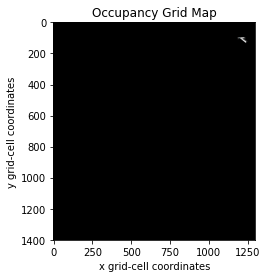

Encoder Counter: 0
Lidar Counter: 5
Encoder Counter: 0
Encoder Counter: 1
Encoder Counter: 2
Encoder Counter: 3
Encoder Counter: 4
Lidar Counter: 5
Encoder Counter: 5
Encoder Counter: 6
Encoder Counter: 7
Encoder Counter: 8
Encoder Counter: 9
Lidar Counter: 10
Encoder Counter: 10
Encoder Counter: 11
Encoder Counter: 12
Encoder Counter: 13
Encoder Counter: 14
Lidar Counter: 15
Encoder Counter: 15
Encoder Counter: 16
Encoder Counter: 17
Encoder Counter: 18
Encoder Counter: 19
Lidar Counter: 20
Encoder Counter: 20
Encoder Counter: 21
Encoder Counter: 22
Encoder Counter: 23
Encoder Counter: 24
Lidar Counter: 25
Encoder Counter: 25
Encoder Counter: 26
Encoder Counter: 27
Encoder Counter: 28
Encoder Counter: 29
Lidar Counter: 30
Encoder Counter: 30
Encoder Counter: 31
Encoder Counter: 32
Encoder Counter: 33
Encoder Counter: 34
Lidar Counter: 35
Encoder Counter: 35
Encoder Counter: 36
Encoder Counter: 37
Encoder Counter: 38
Encoder Counter: 39
Lidar Counter: 40
Encoder Counter: 40
Encoder Cou

/tmp/ipykernel_7321/1745675250.py:142: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  output_map = ((1 - 1 / (1 + np.exp(MAP['map']))) < 0.1).astype(np.int)


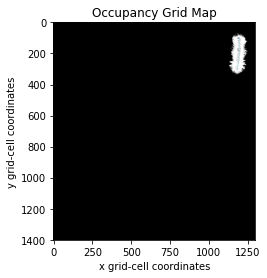

Encoder Counter: 3000
Lidar Counter: 3000
Encoder Counter: 3000
Encoder Counter: 3001
Encoder Counter: 3002
Encoder Counter: 3003
Encoder Counter: 3004
Lidar Counter: 3000
Encoder Counter: 3005
Encoder Counter: 3006
Encoder Counter: 3007
Encoder Counter: 3008
Encoder Counter: 3009
Lidar Counter: 3005
Encoder Counter: 3010
Encoder Counter: 3011
Encoder Counter: 3012
Encoder Counter: 3013
Encoder Counter: 3014
Lidar Counter: 3010
Encoder Counter: 3015
Encoder Counter: 3016
Encoder Counter: 3017
Encoder Counter: 3018
Encoder Counter: 3019
Lidar Counter: 3015
Encoder Counter: 3020
Encoder Counter: 3021
Encoder Counter: 3022
Encoder Counter: 3023
Encoder Counter: 3024
Lidar Counter: 3020
Encoder Counter: 3025
Encoder Counter: 3026
Encoder Counter: 3027
Encoder Counter: 3028
Encoder Counter: 3029
Lidar Counter: 3025
Encoder Counter: 3030
Encoder Counter: 3031
Encoder Counter: 3032
Encoder Counter: 3033
Encoder Counter: 3034
Lidar Counter: 3030
Encoder Counter: 3035
Encoder Counter: 3036
Enco

/tmp/ipykernel_7321/1745675250.py:142: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  output_map = ((1 - 1 / (1 + np.exp(MAP['map']))) < 0.1).astype(np.int)


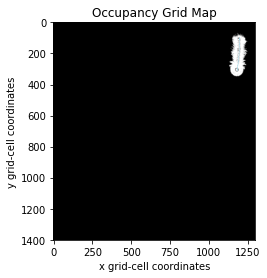

Encoder Counter: 6000
Lidar Counter: 5995
Encoder Counter: 6000
Encoder Counter: 6001
Encoder Counter: 6002
Encoder Counter: 6003
Encoder Counter: 6004
Lidar Counter: 5995
Encoder Counter: 6005
Encoder Counter: 6006
Encoder Counter: 6007
Encoder Counter: 6008
Encoder Counter: 6009
Lidar Counter: 6000
Encoder Counter: 6010
Encoder Counter: 6011
Encoder Counter: 6012
Encoder Counter: 6013
Encoder Counter: 6014
Lidar Counter: 6005
Encoder Counter: 6015
Encoder Counter: 6016
Encoder Counter: 6017
Encoder Counter: 6018
Encoder Counter: 6019
Lidar Counter: 6010
Encoder Counter: 6020
Encoder Counter: 6021
Encoder Counter: 6022
Encoder Counter: 6023
Encoder Counter: 6024
Lidar Counter: 6015
Encoder Counter: 6025
Encoder Counter: 6026
Encoder Counter: 6027
Encoder Counter: 6028
Encoder Counter: 6029
Lidar Counter: 6020
Encoder Counter: 6030
Encoder Counter: 6031
Encoder Counter: 6032
Encoder Counter: 6033
Encoder Counter: 6034
Lidar Counter: 6025
Encoder Counter: 6035
Encoder Counter: 6036
Enco

/tmp/ipykernel_7321/1745675250.py:142: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  output_map = ((1 - 1 / (1 + np.exp(MAP['map']))) < 0.1).astype(np.int)


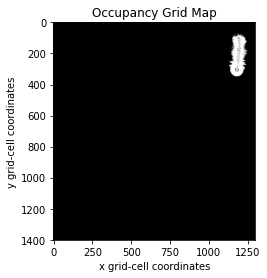

Encoder Counter: 9000
Lidar Counter: 8990
Encoder Counter: 9000
Encoder Counter: 9001
Encoder Counter: 9002
Encoder Counter: 9003
Lidar Counter: 8990
Encoder Counter: 9004
Encoder Counter: 9005
Encoder Counter: 9006
Encoder Counter: 9007
Encoder Counter: 9008
Lidar Counter: 8995
Encoder Counter: 9009
Encoder Counter: 9010
Encoder Counter: 9011
Encoder Counter: 9012
Encoder Counter: 9013
Lidar Counter: 9000
Encoder Counter: 9014
Encoder Counter: 9015
Encoder Counter: 9016
Encoder Counter: 9017
Encoder Counter: 9018
Lidar Counter: 9005
Encoder Counter: 9019
Encoder Counter: 9020
Encoder Counter: 9021
Encoder Counter: 9022
Encoder Counter: 9023
Lidar Counter: 9010
Encoder Counter: 9024
Encoder Counter: 9025
Encoder Counter: 9026
Encoder Counter: 9027
Encoder Counter: 9028
Lidar Counter: 9015
Encoder Counter: 9029
Encoder Counter: 9030
Encoder Counter: 9031
Encoder Counter: 9032
Encoder Counter: 9033
Lidar Counter: 9020
Encoder Counter: 9034
Encoder Counter: 9035
Encoder Counter: 9036
Enco

KeyboardInterrupt: 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pr2_utils import *
# from process_lidar_data import process_Lidar_Data
# from utility import *

# Variable Definitions

MAP                 = {}
log_Odds_Ratio      = np.log(4)
delta_Yaw           = np.zeros(116048)
dt                  = np.zeros(116048)
X                   = np.zeros((116048, 3))
X[0]                = np.array([0,0,0]) # Initializing the first element of X at 0
trajectory          = np.zeros((1,2))
theta               = 0 # General variable for angle
encoder_Counter     = 0
lidar_Counter       = 0

# Encoder Parameters

left_Wheel_Dia      = 0.623479 # Meters
right_Wheel_Dia     = 0.622806 # Meters
enc_Resolution      = 4096

# Particles Parameters

particle_Count      = 3
particle_Weights    = np.zeros((1, particle_Count))
particle_State      = np.zeros((particle_Count, 3))

# Main Code starts from here

# Load Data for all the sensors
timestamp_Lidar, data_Lidar             = initialize_Lidar()
timestamp_Encoder, data_Encoder         = initialize_Encoder()
timestamp_FOG, data_FOG                 = initialize_FOG()

# Initialize MAP
MAP, x_im, y_im, x_range, y_range       = initialize_Map(MAP)

# Sync Encoder and FOG Data
delta_Yaw, dt                           = sync_Encoder_FOG_Data(data_FOG, timestamp_Encoder)

# Initialize Particle Weights
particle_Weights[0, 0:particle_Count]   = 1/particle_Count

# Update Map with the first Lidar Scan
xs0, ys0                                = process_Lidar_Data( data_Lidar[lidar_Counter,:], X[0] )
MAP                                     = update_Map( MAP, xs0, ys0, X[0], log_Odds_Ratio )

# Main Loop
for encoder_Counter in range( len( timestamp_Encoder ) - 1 ):

    left_Wheel_Distance     = ( (data_Encoder[encoder_Counter+1, 0] - data_Encoder[encoder_Counter, 0]) * np.pi * left_Wheel_Dia )/ enc_Resolution
    right_Wheel_Distance    = ( (data_Encoder[encoder_Counter+1, 1] - data_Encoder[encoder_Counter, 1]) * np.pi * right_Wheel_Dia )/ enc_Resolution

    delta_distance          = ( left_Wheel_Distance + right_Wheel_Distance ) / 2

    theta                   = theta + delta_Yaw[encoder_Counter]
    #X[encoder_Counter+1]    = X[encoder_Counter] + np.array( [ delta_distance * np.cos(theta), delta_distance * np.sin(theta), theta ])
    particle_State          = particle_State + np.array( [ delta_distance * np.cos(theta), delta_distance * np.sin(theta), theta ])
    particle_State          = add_Noise( particle_State, particle_Count, dt[encoder_Counter] )

    if timestamp_Lidar[lidar_Counter] < timestamp_Encoder[encoder_Counter]:

        state_Matched_Particle      = calculate_Map_Correlation(data_Lidar[lidar_Counter,:], particle_Count, particle_State, particle_Weights, MAP, x_im, y_im, x_range, y_range)
        xs0, ys0                    = process_Lidar_Data( data_Lidar[lidar_Counter,:], state_Matched_Particle )
        MAP                         = update_Map( MAP, xs0, ys0, state_Matched_Particle, log_Odds_Ratio )

        # Uncomment these lines to run without the particles
        # xs0, ys0                    = process_Lidar_Data( data_Lidar[lidar_Counter,:], X[encoder_Counter] )
        # MAP                         = update_Map( MAP, xs0, ys0, X[encoder_Counter], log_Odds_Ratio )

        print('Lidar Counter:', lidar_Counter)
        lidar_Counter               += 5

    # Save Trajectory
    X[encoder_Counter]      = state_Matched_Particle
    trajectory              = np.concatenate( ( trajectory, np.array( [[X[encoder_Counter,0], X[encoder_Counter,1]]] ) ), axis = 0 )

    if (lidar_Counter == len(data_Lidar)):
        break

    if encoder_Counter % 3000 == 0:

        x,y = superimpose_Trajectory(trajectory, MAP)
        plot_Map(MAP, x,y)
        print('Encoder Counter:', encoder_Counter)
        print('Lidar Counter:', lidar_Counter)

    print('Encoder Counter:', encoder_Counter)

# Plot the Final Map
#X = X[~np.all(X == 0, axis=1)]
#x,y = superimpose_Trajectory(X)
#plot_Map(MAP, y, x)